In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
import tensorflow as tf
import scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

file_path = 'dataset/Wednesday-workingHours.pcap_ISCX.csv'
data = pd.read_csv(file_path)

df = data.copy()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

X = df.drop('Label', axis=1)
y = df['Label']
y_binary = np.where(y == 'BENIGN', 0, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.15, random_state=42, stratify=y_binary
)

print(f"Train 데이터 크기: {X_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}")
print("-" * 50)

Train 데이터 크기: (588797, 78)
Test 데이터 크기: (103906, 78)
--------------------------------------------------


In [3]:
print("## LSTM 모델 학습 및 평가 ##")

# 데이터 스케일링
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM 입력 형태에 맞게 데이터 재구성 (samples, timesteps, features)
# 여기서는 각 샘플을 1개의 타임스텝으로 간주
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

def create_lstm_model(lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='relu',
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# LSTM 모델 정의
lstm_model = KerasClassifier(build_fn=create_lstm_model)

grid_params = {
    'epochs': [10, 25, 50],
    'batch_size': [32, 64]
}
grid_search = GridSearchCV(estimator=lstm_model, param_grid=grid_params, cv=3, scoring='accuracy' , verbose=1)
grid_search.fit(X_train_lstm, y_train)

print("최적의 파라미터:", grid_search.best_params_)
lstm_best_model = grid_search.best_estimator_



## LSTM 모델 학습 및 평가 ##
Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0469 - accuracy: 0.9829
Epoch 2/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0180 - accuracy: 0.9950
Epoch 3/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0156 - accuracy: 0.9960
Epoch 4/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0146 - accuracy: 0.9964
Epoch 5/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0139 - accuracy: 0.9964
Epoch 6/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0134 - accuracy: 0.9965
Epoch 7/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0130 - accuracy: 0.9967
Epoch 8/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0131 - accuracy: 0.9967
Epoch 9/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0125 - accuracy: 0.9969
Epoch 10/10
6134/6134 [==============================] 

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0481 - accuracy: 0.9827
Epoch 2/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0193 - accuracy: 0.9947
Epoch 3/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0166 - accuracy: 0.9958
Epoch 4/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0152 - accuracy: 0.9961
Epoch 5/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0141 - accuracy: 0.9963
Epoch 6/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0142 - accuracy: 0.9963
Epoch 7/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0135 - accuracy: 0.9965
Epoch 8/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0130 - accuracy: 0.9965
Epoch 9/10
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0128 - accuracy: 0.9966
Epoch 10/10
6134/6134 [==============================] 

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12267/12267 [==============================] - 26s 2ms/step - loss: 0.0479 - accuracy: 0.9828
Epoch 2/10
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0182 - accuracy: 0.9949
Epoch 3/10
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0155 - accuracy: 0.9959
Epoch 4/10
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0146 - accuracy: 0.9962
Epoch 5/10
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0138 - accuracy: 0.9963
Epoch 6/10
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0132 - accuracy: 0.9965
Epoch 7/10
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0128 - accuracy: 0.9966
Epoch 8/10
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0123 - accuracy: 0.9967
Epoch 9/10
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0120 - accuracy: 0.9967
Epoch 10/10
6134/6134 [==============================] 

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0475 - accuracy: 0.9829
Epoch 2/25
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0188 - accuracy: 0.9948
Epoch 3/25
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0155 - accuracy: 0.9960
Epoch 4/25
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0146 - accuracy: 0.9963
Epoch 5/25
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0137 - accuracy: 0.9964
Epoch 6/25
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0136 - accuracy: 0.9966
Epoch 7/25
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0131 - accuracy: 0.9967
Epoch 8/25
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0129 - accuracy: 0.9967
Epoch 9/25
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0124 - accuracy: 0.9968
Epoch 10/25
12267/12267 [==============================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0478 - accuracy: 0.9828
Epoch 2/25
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0190 - accuracy: 0.9948
Epoch 3/25
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0164 - accuracy: 0.9957
Epoch 4/25
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0151 - accuracy: 0.9961
Epoch 5/25
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0143 - accuracy: 0.9962
Epoch 6/25
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0135 - accuracy: 0.9964
Epoch 7/25
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0133 - accuracy: 0.9965
Epoch 8/25
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0126 - accuracy: 0.9966
Epoch 9/25
12267/12267 [==============================] - 22s 2ms/step - loss: 0.0126 - accuracy: 0.9966
Epoch 10/25
12267/12267 [==============================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
12267/12267 [==============================] - 28s 2ms/step - loss: 0.0490 - accuracy: 0.9827
Epoch 2/25
12267/12267 [==============================] - 27s 2ms/step - loss: 0.0203 - accuracy: 0.9944
Epoch 3/25
12267/12267 [==============================] - 27s 2ms/step - loss: 0.0163 - accuracy: 0.9961
Epoch 4/25
12267/12267 [==============================] - 27s 2ms/step - loss: 0.0151 - accuracy: 0.9963
Epoch 5/25
12267/12267 [==============================] - 27s 2ms/step - loss: 0.0144 - accuracy: 0.9964
Epoch 6/25
12267/12267 [==============================] - 27s 2ms/step - loss: 0.0135 - accuracy: 0.9966
Epoch 7/25
12267/12267 [==============================] - 27s 2ms/step - loss: 0.0129 - accuracy: 0.9967
Epoch 8/25
12267/12267 [==============================] - 27s 2ms/step - loss: 0.0124 - accuracy: 0.9967
Epoch 9/25
12267/12267 [==============================] - 27s 2ms/step - loss: 0.0119 - accuracy: 0.9968
Epoch 10/25
12267/12267 [==============================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
12267/12267 [==============================] - 26s 2ms/step - loss: 0.0474 - accuracy: 0.9826
Epoch 2/50
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0190 - accuracy: 0.9948
Epoch 3/50
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0155 - accuracy: 0.9960
Epoch 4/50
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0149 - accuracy: 0.9962
Epoch 5/50
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0145 - accuracy: 0.9965
Epoch 6/50
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0135 - accuracy: 0.9965
Epoch 7/50
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0134 - accuracy: 0.9966
Epoch 8/50
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0126 - accuracy: 0.9967
Epoch 9/50
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0125 - accuracy: 0.9968
Epoch 10/50
12267/12267 [==============================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
12267/12267 [==============================] - 25s 2ms/step - loss: 0.0478 - accuracy: 0.9828
Epoch 2/50
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0193 - accuracy: 0.9947
Epoch 3/50
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0165 - accuracy: 0.9959
Epoch 4/50
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0150 - accuracy: 0.9961
Epoch 5/50
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0144 - accuracy: 0.9962
Epoch 6/50
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0136 - accuracy: 0.9964
Epoch 7/50
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0135 - accuracy: 0.9965
Epoch 8/50
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0131 - accuracy: 0.9964
Epoch 9/50
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0125 - accuracy: 0.9966
Epoch 10/50
12267/12267 [==============================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0481 - accuracy: 0.9831
Epoch 2/50
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0190 - accuracy: 0.9951
Epoch 3/50
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0159 - accuracy: 0.9960
Epoch 4/50
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0148 - accuracy: 0.9962
Epoch 5/50
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0142 - accuracy: 0.9964
Epoch 6/50
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0133 - accuracy: 0.9965
Epoch 7/50
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0129 - accuracy: 0.9966
Epoch 8/50
12267/12267 [==============================] - 24s 2ms/step - loss: 0.0125 - accuracy: 0.9967
Epoch 9/50
12267/12267 [==============================] - 23s 2ms/step - loss: 0.0119 - accuracy: 0.9968
Epoch 10/50
12267/12267 [==============================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
6134/6134 [==============================] - 20s 3ms/step - loss: 0.0566 - accuracy: 0.9790
Epoch 2/10
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0217 - accuracy: 0.9931
Epoch 3/10
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0155 - accuracy: 0.9960
Epoch 4/10
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0140 - accuracy: 0.9964
Epoch 5/10
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0137 - accuracy: 0.9964
Epoch 6/10
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0131 - accuracy: 0.9966
Epoch 7/10
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0128 - accuracy: 0.9967
Epoch 8/10
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0125 - accuracy: 0.9967
Epoch 9/10
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0121 - accuracy: 0.9968
Epoch 10/10
3067/3067 [==============================] - 4s 1ms/step


c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0566 - accuracy: 0.9791
Epoch 2/10
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0238 - accuracy: 0.9926
Epoch 3/10
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0172 - accuracy: 0.9956
Epoch 4/10
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0153 - accuracy: 0.9961
Epoch 5/10
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0142 - accuracy: 0.9963
Epoch 6/10
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0139 - accuracy: 0.9964
Epoch 7/10
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0134 - accuracy: 0.9964
Epoch 8/10
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0125 - accuracy: 0.9966
Epoch 9/10
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0125 - accuracy: 0.9966
Epoch 10/10
3067/3067 [==============================] - 3s 923us/step


c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0563 - accuracy: 0.9793
Epoch 2/10
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0206 - accuracy: 0.9939
Epoch 3/10
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0154 - accuracy: 0.9960
Epoch 4/10
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0141 - accuracy: 0.9963
Epoch 5/10
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0132 - accuracy: 0.9964
Epoch 6/10
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0127 - accuracy: 0.9965
Epoch 7/10
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0123 - accuracy: 0.9966
Epoch 8/10
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0119 - accuracy: 0.9968
Epoch 9/10
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0116 - accuracy: 0.9968
Epoch 10/10
3067/3067 [==============================] - 3s 933us/step


c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0574 - accuracy: 0.9789
Epoch 2/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0227 - accuracy: 0.9927
Epoch 3/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0156 - accuracy: 0.9959
Epoch 4/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0141 - accuracy: 0.9962
Epoch 5/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0134 - accuracy: 0.9965
Epoch 6/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0131 - accuracy: 0.9966
Epoch 7/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0126 - accuracy: 0.9966
Epoch 8/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0124 - accuracy: 0.9968
Epoch 9/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0119 - accuracy: 0.9969
Epoch 10/25
6134/6134 [==============================] - 14s 2ms/step - l

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
6134/6134 [==============================] - 16s 2ms/step - loss: 0.0577 - accuracy: 0.9790
Epoch 2/25
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0230 - accuracy: 0.9930
Epoch 3/25
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0162 - accuracy: 0.9957
Epoch 4/25
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0147 - accuracy: 0.9961
Epoch 5/25
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0141 - accuracy: 0.9963
Epoch 6/25
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0131 - accuracy: 0.9965
Epoch 7/25
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0132 - accuracy: 0.9965
Epoch 8/25
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0126 - accuracy: 0.9966
Epoch 9/25
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0120 - accuracy: 0.9967
Epoch 10/25
6134/6134 [==============================] - 15s 2ms/step - l

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
6134/6134 [==============================] - 15s 2ms/step - loss: 0.0557 - accuracy: 0.9799
Epoch 2/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0218 - accuracy: 0.9935
Epoch 3/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0161 - accuracy: 0.9959
Epoch 4/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0146 - accuracy: 0.9963
Epoch 5/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0136 - accuracy: 0.9965
Epoch 6/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0129 - accuracy: 0.9967
Epoch 7/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0128 - accuracy: 0.9967
Epoch 8/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0126 - accuracy: 0.9967
Epoch 9/25
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0121 - accuracy: 0.9968
Epoch 10/25
6134/6134 [==============================] - 14s 2ms/step - l

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
6134/6134 [==============================] - 14s 2ms/step - loss: 0.0552 - accuracy: 0.9799
Epoch 2/50
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0216 - accuracy: 0.9932
Epoch 3/50
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0156 - accuracy: 0.9959
Epoch 4/50
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0145 - accuracy: 0.9963
Epoch 5/50
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0135 - accuracy: 0.9966
Epoch 6/50
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0130 - accuracy: 0.9966
Epoch 7/50
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0129 - accuracy: 0.9967
Epoch 8/50
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0123 - accuracy: 0.9968
Epoch 9/50
6134/6134 [==============================] - 13s 2ms/step - loss: 0.0119 - accuracy: 0.9968
Epoch 10/50
6134/6134 [==============================] - 13s 2ms/step - l

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
6134/6134 [==============================] - 20s 3ms/step - loss: 0.0573 - accuracy: 0.9788
Epoch 2/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0216 - accuracy: 0.9937
Epoch 3/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0163 - accuracy: 0.9957
Epoch 4/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0148 - accuracy: 0.9962
Epoch 5/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0138 - accuracy: 0.9964
Epoch 6/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0132 - accuracy: 0.9965
Epoch 7/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0128 - accuracy: 0.9966
Epoch 8/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0124 - accuracy: 0.9966
Epoch 9/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0123 - accuracy: 0.9967
Epoch 10/50
6134/6134 [==============================] - 19s 3ms/step - l

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
6134/6134 [==============================] - 20s 3ms/step - loss: 0.0564 - accuracy: 0.9796
Epoch 2/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0228 - accuracy: 0.9932
Epoch 3/50
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0168 - accuracy: 0.9958
Epoch 4/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0150 - accuracy: 0.9963
Epoch 5/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0138 - accuracy: 0.9966
Epoch 6/50
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0131 - accuracy: 0.9966
Epoch 7/50
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0125 - accuracy: 0.9967
Epoch 8/50
6134/6134 [==============================] - 19s 3ms/step - loss: 0.0123 - accuracy: 0.9967
Epoch 9/50
6134/6134 [==============================] - 18s 3ms/step - loss: 0.0118 - accuracy: 0.9968
Epoch 10/50
6134/6134 [==============================] - 18s 3ms/step - l

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
18400/18400 [==============================] - 41s 2ms/step - loss: 0.0396 - accuracy: 0.9865
Epoch 2/50
18400/18400 [==============================] - 40s 2ms/step - loss: 0.0171 - accuracy: 0.9958
Epoch 3/50
18400/18400 [==============================] - 40s 2ms/step - loss: 0.0150 - accuracy: 0.9963
Epoch 4/50
18400/18400 [==============================] - 40s 2ms/step - loss: 0.0141 - accuracy: 0.9965
Epoch 5/50
18400/18400 [==============================] - 40s 2ms/step - loss: 0.0134 - accuracy: 0.9965
Epoch 6/50
18400/18400 [==============================] - 40s 2ms/step - loss: 0.0127 - accuracy: 0.9967
Epoch 7/50
18400/18400 [==============================] - 40s 2ms/step - loss: 0.0125 - accuracy: 0.9967
Epoch 8/50
18400/18400 [==============================] - 40s 2ms/step - loss: 0.0122 - accuracy: 0.9968
Epoch 9/50
18400/18400 [==============================] - 40s 2ms/step - loss: 0.0119 - accuracy: 0.9968
Epoch 10/50
18400/18400 [==============================

In [6]:

# 모델 평가
loss, accuracy = lstm_best_model.model_.evaluate(X_test_lstm, y_test, verbose=0)
y_pred_lstm_proba = lstm_best_model.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int)

print(f"LSTM 모델 정확도: {accuracy:.4f}")
print(f"LSTM 모델 재현율 (Recall): {recall_score(y_test, y_pred_lstm):.4f}")
print(f"LSTM 모델 F1-Score: {f1_score(y_test, y_pred_lstm):.4f}")
print("LSTM 모델 성능 리포트:")
print(classification_report(y_test, y_pred_lstm, target_names=['BENIGN (0)', 'ATTACK (1)']))
print("-" * 50)

3248/3248 [==============================] - 3s 1ms/step
LSTM 모델 정확도: 0.9972
LSTM 모델 재현율 (Recall): 0.9998
LSTM 모델 F1-Score: 0.9961
LSTM 모델 성능 리포트:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00     66005
  ATTACK (1)       0.99      1.00      1.00     37901

    accuracy                           1.00    103906
   macro avg       1.00      1.00      1.00    103906
weighted avg       1.00      1.00      1.00    103906

--------------------------------------------------


3248/3248 [==============================] - 3s 1ms/step


Text(0.5, 1.0, 'ROC Curve for LSTM Model')

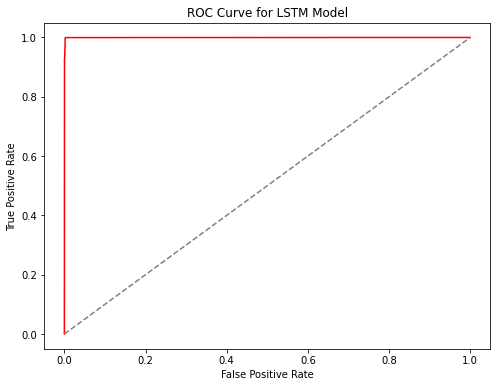

In [7]:
## ROC 곡선 및 AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_lstm_proba = lstm_best_model.predict_proba(X_test_lstm)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lstm_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'LSTM (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title('ROC Curve for LSTM Model')

In [8]:
import joblib
import os

save_path = 'models/lstm_model.pkl'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
joblib.dump(lstm_best_model, save_path)
print(f"LSTM 모델이 {save_path}에 저장되었습니다.")

INFO:tensorflow:Assets written to: C:\Users\csp\AppData\Local\Temp\tmpg412xt_d\assets


INFO:tensorflow:Assets written to: C:\Users\csp\AppData\Local\Temp\tmpg412xt_d\assets


LSTM 모델이 models/lstm_model.pkl에 저장되었습니다.
